### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [3]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = '../data/training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [6]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 印出網路結構
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1664/1712 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 00001: val_loss improved from inf to 0.00241, saving model to best_weights.h5
1712/1712 [==============================] - 4s 2ms/sample - loss: 0.0076 - val_loss: 0.0024
Epoch 2/150
1536/1712 [=========================>....] - ETA: 0s - loss: 0.0021
Epoch 00002: val_loss improved from 0.00241 to 0.00207, saving model to best_weights.h5
1712/1712 [==============================] - 1s 465us/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 3/150
1600/1712 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00003: val_loss improved from 0.00207 to 0.00190, saving model to best_weights.h5
1712/1712 [==============================] - 1s 448us/sample - loss: 0.0015 - val_loss: 0.0019
Epoch 4/150
1600/1712 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00004: val_loss improved from 0.00190 to 0.00185, saving model to best_weights.h5
17

Epoch 32/150
1536/1712 [=========================>....] - ETA: 0s - loss: 2.4828e-04
Epoch 00032: val_loss did not improve from 0.00080
1712/1712 [==============================] - 1s 427us/sample - loss: 2.4796e-04 - val_loss: 8.4324e-04
Epoch 33/150
1664/1712 [============================>.] - ETA: 0s - loss: 2.3801e-04
Epoch 00033: val_loss improved from 0.00080 to 0.00079, saving model to best_weights.h5
1712/1712 [==============================] - 1s 459us/sample - loss: 2.3820e-04 - val_loss: 7.9460e-04
Epoch 34/150
1600/1712 [===========================>..] - ETA: 0s - loss: 2.3743e-04
Epoch 00034: val_loss did not improve from 0.00079
1712/1712 [==============================] - 1s 417us/sample - loss: 2.3712e-04 - val_loss: 7.9902e-04
Epoch 35/150
1536/1712 [=========================>....] - ETA: 0s - loss: 2.3240e-04
Epoch 00035: val_loss did not improve from 0.00079
1712/1712 [==============================] - 1s 422us/sample - loss: 2.3408e-04 - val_loss: 8.0025e-04
Epoch 3

1664/1712 [============================>.] - ETA: 0s - loss: 1.5925e-04
Epoch 00065: val_loss did not improve from 0.00074
1712/1712 [==============================] - 1s 421us/sample - loss: 1.5887e-04 - val_loss: 7.5894e-04
Epoch 66/150
1600/1712 [===========================>..] - ETA: 0s - loss: 1.5397e-04
Epoch 00066: val_loss did not improve from 0.00074
1712/1712 [==============================] - 1s 419us/sample - loss: 1.5425e-04 - val_loss: 7.7066e-04
Epoch 67/150
1600/1712 [===========================>..] - ETA: 0s - loss: 1.5330e-04
Epoch 00067: val_loss did not improve from 0.00074
1712/1712 [==============================] - 1s 420us/sample - loss: 1.5365e-04 - val_loss: 7.3636e-04
Epoch 68/150
1536/1712 [=========================>....] - ETA: 0s - loss: 1.6111e-04
Epoch 00068: val_loss did not improve from 0.00074
1712/1712 [==============================] - 1s 418us/sample - loss: 1.6014e-04 - val_loss: 7.4369e-04
Epoch 69/150
1664/1712 [============================>.] -

1600/1712 [===========================>..] - ETA: 0s - loss: 1.1494e-04
Epoch 00099: val_loss did not improve from 0.00073
1712/1712 [==============================] - 1s 417us/sample - loss: 1.1527e-04 - val_loss: 7.7596e-04
Epoch 100/150
1664/1712 [============================>.] - ETA: 0s - loss: 1.1681e-04
Epoch 00100: val_loss did not improve from 0.00073
1712/1712 [==============================] - 1s 420us/sample - loss: 1.1652e-04 - val_loss: 7.7007e-04
Epoch 101/150
1600/1712 [===========================>..] - ETA: 0s - loss: 1.1530e-04
Epoch 00101: val_loss improved from 0.00073 to 0.00073, saving model to best_weights.h5
1712/1712 [==============================] - 1s 458us/sample - loss: 1.1678e-04 - val_loss: 7.2542e-04
Epoch 102/150
1600/1712 [===========================>..] - ETA: 0s - loss: 1.1855e-04
Epoch 00102: val_loss did not improve from 0.00073
1712/1712 [==============================] - 1s 416us/sample - loss: 1.1905e-04 - val_loss: 7.2695e-04
Epoch 103/150
160

1536/1712 [=========================>....] - ETA: 0s - loss: 9.5272e-05
Epoch 00133: val_loss did not improve from 0.00073
1712/1712 [==============================] - 1s 419us/sample - loss: 9.5837e-05 - val_loss: 7.6979e-04
Epoch 134/150
1600/1712 [===========================>..] - ETA: 0s - loss: 9.3105e-05
Epoch 00134: val_loss did not improve from 0.00073
1712/1712 [==============================] - 1s 418us/sample - loss: 9.3439e-05 - val_loss: 7.9434e-04
Epoch 135/150
1664/1712 [============================>.] - ETA: 0s - loss: 9.2853e-05
Epoch 00135: val_loss did not improve from 0.00073
1712/1712 [==============================] - 1s 421us/sample - loss: 9.2919e-05 - val_loss: 7.6370e-04
Epoch 136/150
1600/1712 [===========================>..] - ETA: 0s - loss: 9.3848e-05
Epoch 00136: val_loss did not improve from 0.00073
1712/1712 [==============================] - 1s 418us/sample - loss: 9.3599e-05 - val_loss: 7.5999e-04
Epoch 137/150
1600/1712 [===========================>.

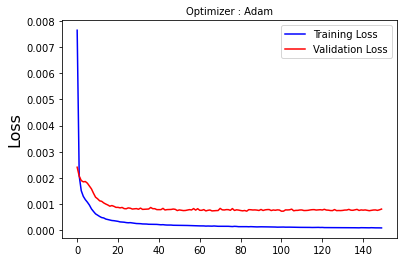

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [12]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = '../data/test.csv')

In [13]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

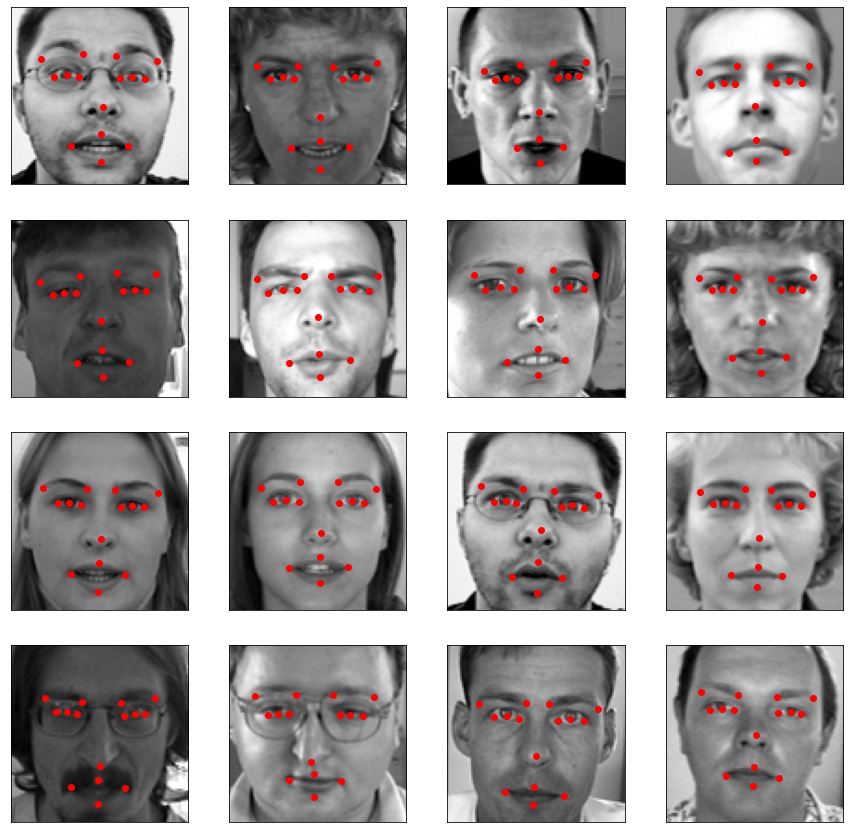

In [14]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [15]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
# Your code

In [17]:
import cv2

In [18]:
# 1. 圖片左右反轉
# 2. 關鍵點調整
def augment_data(img, points):
    new_img = cv2.flip(img, 1)
    new_points = np.copy(points)
    
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
    
    return new_img, new_points

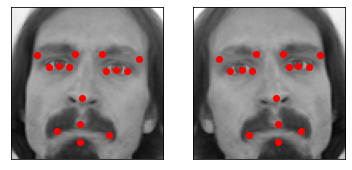

In [19]:
# 畫出來看
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [20]:
# 原data shape
imgs_train.shape

(2140, 96, 96)

In [21]:
# 做 augmentation data
new_img_list = []
new_points_list = []
for img, points in zip(imgs_train, points_train):
    new_img, new_points = augment_data(img, points)
    new_img_list.append(new_img)
    new_points_list.append(points)

In [22]:
# 跟原data合併
aug_imgs_train = np.vstack((imgs_train, np.array(new_img_list)))
aug_points_train = np.vstack((points_train, np.array(new_points_list)))

In [23]:
print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [24]:
# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_aug.h5', verbose=1, save_best_only=True)
hist_aug = History()

In [25]:
# training the model
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(-1, 96, 96, 1), 
                                        aug_points_train, 
                                        validation_split=0.2, 
                                        batch_size=64, 
                                        callbacks=[checkpoint_aug, hist_aug],
                                        shuffle=True, 
                                        epochs=150, 
                                        verbose=1)

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3264/3424 [===========================>..] - ETA: 0s - loss: 0.0062
Epoch 00001: val_loss improved from inf to 0.00165, saving model to best_weights_aug.h5
3424/3424 [==============================] - 2s 684us/sample - loss: 0.0060 - val_loss: 0.0017
Epoch 2/150
3328/3424 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00002: val_loss improved from 0.00165 to 0.00158, saving model to best_weights_aug.h5
3424/3424 [==============================] - 1s 436us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 3/150
3264/3424 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00003: val_loss improved from 0.00158 to 0.00152, saving model to best_weights_aug.h5
3424/3424 [==============================] - 1s 435us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 4/150
3264/3424 [===========================>..] - ETA: 0s - loss: 0.0011
Epoch 00004: val_loss improved from 0.00152 to 0.00141, saving model to best

Epoch 35/150
3264/3424 [===========================>..] - ETA: 0s - loss: 2.3895e-04
Epoch 00035: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 418us/sample - loss: 2.3922e-04 - val_loss: 0.0019
Epoch 36/150
3328/3424 [============================>.] - ETA: 0s - loss: 2.4197e-04
Epoch 00036: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 420us/sample - loss: 2.4108e-04 - val_loss: 0.0019
Epoch 37/150
3392/3424 [============================>.] - ETA: 0s - loss: 2.3577e-04
Epoch 00037: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 417us/sample - loss: 2.3570e-04 - val_loss: 0.0018
Epoch 38/150
3264/3424 [===========================>..] - ETA: 0s - loss: 2.3270e-04
Epoch 00038: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 421us/sample - loss: 2.3229e-04 - val_loss: 0.0019
Epoch 39/150
3392/3424 [============================>.] - ET

Epoch 70/150
3264/3424 [===========================>..] - ETA: 0s - loss: 1.4656e-04
Epoch 00070: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 418us/sample - loss: 1.4686e-04 - val_loss: 0.0019
Epoch 71/150
3328/3424 [============================>.] - ETA: 0s - loss: 1.4428e-04
Epoch 00071: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 419us/sample - loss: 1.4385e-04 - val_loss: 0.0018
Epoch 72/150
3264/3424 [===========================>..] - ETA: 0s - loss: 1.4305e-04
Epoch 00072: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 419us/sample - loss: 1.4360e-04 - val_loss: 0.0017
Epoch 73/150
3328/3424 [============================>.] - ETA: 0s - loss: 1.4328e-04
Epoch 00073: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 418us/sample - loss: 1.4330e-04 - val_loss: 0.0019
Epoch 74/150
3264/3424 [===========================>..] - ET

Epoch 105/150
3264/3424 [===========================>..] - ETA: 0s - loss: 1.1085e-04
Epoch 00105: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 421us/sample - loss: 1.1047e-04 - val_loss: 0.0017
Epoch 106/150
3392/3424 [============================>.] - ETA: 0s - loss: 1.1072e-04
Epoch 00106: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 418us/sample - loss: 1.1062e-04 - val_loss: 0.0017
Epoch 107/150
3328/3424 [============================>.] - ETA: 0s - loss: 1.1285e-04
Epoch 00107: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 417us/sample - loss: 1.1297e-04 - val_loss: 0.0018
Epoch 108/150
3392/3424 [============================>.] - ETA: 0s - loss: 1.1063e-04
Epoch 00108: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 419us/sample - loss: 1.1069e-04 - val_loss: 0.0018
Epoch 109/150
3392/3424 [============================>.]

Epoch 140/150
3328/3424 [============================>.] - ETA: 0s - loss: 9.7585e-05
Epoch 00140: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 422us/sample - loss: 9.7844e-05 - val_loss: 0.0017
Epoch 141/150
3392/3424 [============================>.] - ETA: 0s - loss: 1.0252e-04
Epoch 00141: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 419us/sample - loss: 1.0250e-04 - val_loss: 0.0017
Epoch 142/150
3328/3424 [============================>.] - ETA: 0s - loss: 9.8466e-05
Epoch 00142: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 418us/sample - loss: 9.8318e-05 - val_loss: 0.0018
Epoch 143/150
3328/3424 [============================>.] - ETA: 0s - loss: 9.9193e-05
Epoch 00143: val_loss did not improve from 0.00138
3424/3424 [==============================] - 1s 419us/sample - loss: 9.9241e-05 - val_loss: 0.0017
Epoch 144/150
3328/3424 [============================>.]

In [26]:
# save the model weights
model_with_augment.save_weights('weights_aug.h5')
# save the model
model_with_augment.save('model_aug.h5')

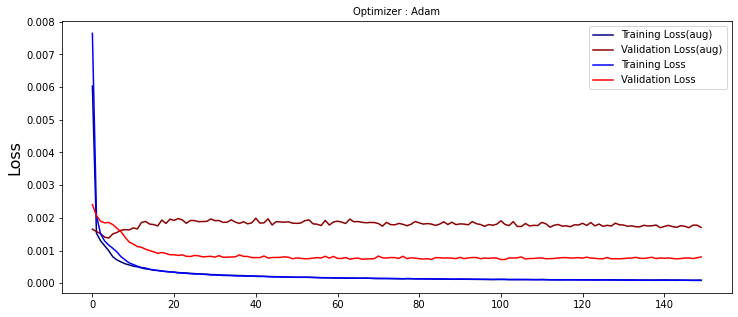

In [27]:
# loss
plt.figure(figsize=(12, 5))
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='navy', label='Training Loss(aug)')
plt.plot(hist_model_aug.history['val_loss'], color='darkred', label='Validation Loss(aug)')
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')